In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines

random_seed = 42

In [2]:
# i.i.d data
# (X_pre, Y_pre): data used to pretrain estimators, such as mean estimator and RF/NN/XGBoost for augmentation
# (X_opt, Y_opt): data used to sovle our optimization problem to get a near 100% coverage
# (X_adj, Y_adj): data used to adjust the interval for 1-alpha coverage
# (X_t, Y_t): data used to test the final performance

In [3]:
# Possible estimators

# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
# Random Forest
# model setup: rf = RandomForestRegressor(n_estimators = 500, random_state = 18)
# training RF: rf.fit(X_pre, Y_pre)
# predict with RF: prediction = rf.predict(X_t)

# XGBoost
# model setup: xgb = XGBRegressor(n_estimators=300,random_state=0)
# training XGBoost: xgb.fit(X_pre,Y_pre)
#prediction with XGBoost: xgb.predict(X_t)


In [4]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t):
    # est_type: "NN1": 1-layer NN; "NN2": 2-layer NN; "rf": random forest; "gb": gradient boosting
    # (X_pre,Y_pre): training data
    # X_opt,X_adj,X_t: data used to predict
    # output: mean estimator m and the predictions m(X)
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_pre = model(torch.from_numpy(X_pre).float())
        M_pre = M_pre.detach().cpu().numpy().reshape(-1,1)
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return M_pre, M_opt, M_adj, M_t
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN2(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_pre = model(torch.from_numpy(X_pre).float())
        M_pre = M_pre.detach().cpu().numpy().reshape(-1,1)
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return M_pre, M_opt, M_adj, M_t
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state=random_seed,criterion='squared_error')
        model.fit(X_pre, Y_pre)
        M_pre = model.predict(X_pre).reshape(-1,1)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return M_pre, M_opt, M_adj, M_t
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "squared_error")
        model.fit(X_pre, Y_pre)
        M_pre = model.predict(X_pre).reshape(-1,1)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return M_pre, M_opt, M_adj, M_t

In [5]:
# train estimator that estimate E[(Y-m_0(X))^2|X=x]
def var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1"):
    X = X_pre
    Y = (Y_pre-M_pre)**2
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X))
            labels=Variable(torch.from_numpy(Y))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        var_opt = model(torch.from_numpy(X_opt).float())
        var_opt = var_opt.detach().cpu().numpy().reshape(-1,1)
        var_opt = np.maximum(var_opt,0)
        var_adj = model(torch.from_numpy(X_adj).float())
        var_adj = var_adj.detach().cpu().numpy().reshape(-1,1)
        var_adj = np.maximum(var_adj,0)
        var_t = model(torch.from_numpy(X_t).float())
        var_t = var_t.detach().cpu().numpy().reshape(-1,1)
        var_t = np.maximum(var_t,0)
        return var_opt, var_adj, var_t

In [6]:
# train quantile estimator that estimate quantile for Y|X

# quantile loss for NN
def quantile_loss(preds, target, quantile):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    errors = target - preds
    q = quantile
    losses = torch.max((q - 1) * errors, q * errors)
    loss = torch.sum(losses)
    return loss

def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    # est_type: "NN1": 1-layer NN; "NN2": 2-layer NN; "qrf": quantile regression forest; "gb": gradient boostin
    # quantile: the quantile we are estimating
    # (X_pre,Y_pre): training data
    # X_opt,X_adj,X_t: data used to predict
    # output: quantile estimator Q and the prediction Q(X)
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN1(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        model = NN2(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state=random_seed)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t

In [7]:
# solve RKHS optimization problem
def RKHS_opt(K, Y):
    n = K.shape[0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(Y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB @ K.T)), constraints)
    prob.solve()
    return hB.value

In [8]:
# Solving the optimization problem
def solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t,
              function_class, E_opt=None, E_adj=None, E_t=None, degree = None,sigma = None):
    # M_opt: mean estimator m(X_opt)
    # function_class: "aug": Augmentation, "rkhs_poly": RKHS with polynomial kernel, "rkhs_rbf": RKHS with RBF kernel
    # E_opt: if function_class = "aug", then E is the estimator matrix, i.e. (E_opt)_{ij} = f_i((X_opt)_j)
    # degree: if function_class = "rkhs_poly", then set the degree of the polynomial
    # sigma: if function_class = "rkhs_rbf", then set parameter sigma
    # (X_opt,Y_opt): data used to solve the optimization problem
    # output: estimator for 100% coverage V_adj and V_t
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_t = X_t.shape[0]
    Y = (Y_opt-M_opt)[:,0]
        
    if function_class == "aug":
        cons_opt = np.ones(n_opt).reshape(1,-1)
        A_opt = np.vstack((E_opt,cons_opt))
        weight = cp.Variable(A_opt.shape[0])
        constraints = [weight>=0]+[weight @ A_opt >= cp.square(Y)]
        prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_opt)), constraints)
        prob.solve()
        optimal_weight = weight.value
        
        cons_adj = np.ones(n_adj).reshape(1,-1)
        A_adj = np.vstack((E_adj,cons_adj))
        V_adj = optimal_weight @ A_adj
        V_adj = V_adj.reshape(-1,1)
        
        cons_t = np.ones(n_t).reshape(1,-1)
        A_t = np.vstack((E_t,cons_t))
        V_t = optimal_weight @ A_t
        V_t = V_t.reshape(-1,1)
        return optimal_weight, V_adj, V_t
    
    if function_class == "rkhs_poly":
        X_inner_prod = X_opt @ X_opt.T
        K = np.power(1 + X_inner_prod, degree)
        hB = RKHS_opt(K,Y)
        
        X_inner_prod_adj = X_adj @ X_opt.T
        K_adj = np.power(1 + X_inner_prod_adj, degree)
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        X_inner_prod_t = X_t @ X_opt.T
        K_t = np.power(1 + X_inner_prod_t, degree)
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t
    
    if function_class == "rkhs_rbf":
        K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
        hB = RKHS_opt(K_opt,Y)
        
        K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t
    
    

In [9]:
# Interval adjustment
def interval_adj(X_adj,Y_adj,M_adj,V_adj,alpha, stepsize=0.001,eps=0):
    # (X_adj,Y_adj): data used to adjust the interval
    # M_adj: mean estimator m(X_adj)
    # V_adj: variance estimator for 100% coverage f(X_adj)
    # alpha: get 1-alpha coverage
    # eps: extend the interval a bit 1/sqrt{log(n_opt)}
    # output: adjustment level delta
    # the prediction level is: [M-sqrt{delta V}, M+sqrt{delta V}]
    I = np.where(V_adj+eps-np.square(Y_adj-M_adj)>=0)[0]
    I.tolist()
    X_adj = X_adj[I].reshape(-1,1)
    Y_adj = Y_adj[I].reshape(-1,1)
    M_adj = M_adj[I].reshape(-1,1)
    V_adj = (V_adj[I]+eps).reshape(-1,1)
    delta = 1
    prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    while prop_outside <= alpha:
        delta = delta-stepsize
        prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    return delta

In [10]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t,ylim,legend_loc='upper right'):
    # (X_t,Y_t): test data
    # M_t: mean estimator m(X_t)
    # V_t: variance estimator f(X_t)
    # The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ylim)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc=legend_loc)
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


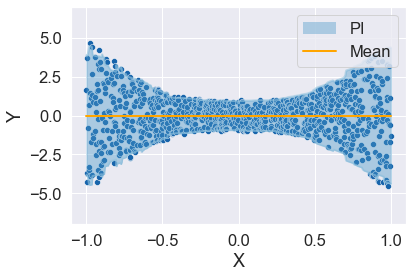

The overall coverage is 0.954
The mean bandwidth for testing data is 5.083659936782228


In [11]:
# Test 1 (known mean case: m_0=0)

# Generate i.i.d data
np.random.seed(5)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


# Obtain mean estimator
known_mean = "True"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
# delta = 1
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-7,7])

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


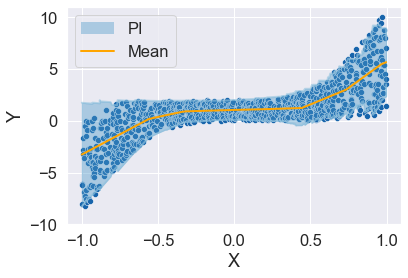

The overall coverage is 0.95
The mean bandwidth for testing data is 5.555909499626152


In [12]:
# Test 2 (unknown mean case)

# Generate i.i.d data
np.random.seed(0)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


# n_pre = 1000
# X_pre = np.random.uniform(-1, 1, n_pre).reshape(-1, 1)
# Y_pre = 1+np.power(X_pre, 3)+np.sqrt(1+np.power(X_pre, 2))  * np.random.uniform(-1, 1, n_pre).reshape(-1, 1)

# n_opt = 100
# X_opt = np.random.uniform(-1, 1, n_opt).reshape(-1, 1)
# Y_opt = 1+np.power(X_opt, 3)+np.sqrt(1+np.power(X_opt, 2))  * np.random.uniform(-1, 1, n_opt).reshape(-1, 1)

# n_adj = 100
# X_adj = np.random.uniform(-1, 1, n_adj).reshape(-1, 1)
# Y_adj = 1+np.power(X_adj, 3)+np.sqrt(1+np.power(X_adj, 2))  * np.random.uniform(-1, 1, n_adj).reshape(-1, 1)

# n_t = 1000
# X_t = np.random.uniform(-1, 1, n_t).reshape(-1, 1)
# Y_t = 1+np.power(X_t, 3)+np.sqrt(1+np.power(X_t, 2))  * np.random.uniform(-1, 1, n_t).reshape(-1, 1)


# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-10,11],legend_loc = 'upper left')

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


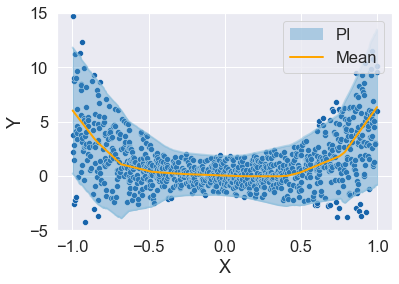

The overall coverage is 0.958
The mean bandwidth for testing data is 14.36100670044848


In [13]:
# Test 3 (\xi depends on X)

# Generate i.i.d data (Y follows a constrained Laplace)
np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

# X = np.random.uniform(-1, 1, n).reshape(-1, 1)
# Y = np.random.laplace(1+5*np.power(X, 3),np.sqrt(1+25*np.power(X, 4)) )
# Y = np.median(np.hstack([np.power(X, 2)+np.power(X, 4)+6,np.power(X, 2)+np.power(X, 4)-6,Y]),axis=1).reshape(-1, 1)

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))

# Specify the bounds for Y
lower_bound = mean_Y - 2 * std_dev_Y
upper_bound = mean_Y + 2 * std_dev_Y

# Generate all Y values initially
Y = np.random.laplace(mean_Y, std_dev_Y)

# Correct values that fall out of bounds
while True:
    out_of_bounds = (Y < lower_bound) | (Y > upper_bound)
    if not np.any(out_of_bounds):
        break
    Y[out_of_bounds] = np.random.laplace(mean_Y[out_of_bounds], std_dev_Y[out_of_bounds])

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)



# n_pre = 1000
# X_pre = np.random.uniform(-1, 1, n_pre).reshape(-1, 1)
# Y_pre = np.random.laplace(X_pre,np.sqrt(1+np.power(X_pre, 2)))
# Y_pre = np.median(np.hstack([X_pre+6,X_pre-6,Y_pre]),axis=1).reshape(-1, 1)


# n_opt = 100
# X_opt = np.random.uniform(-1, 1, n_opt).reshape(-1, 1)
# Y_opt = np.random.laplace(X_opt,np.sqrt(1+np.power(X_opt, 2)))
# Y_opt = np.median(np.hstack([X_opt+6,X_opt-6,Y_opt]),axis=1).reshape(-1, 1)

# n_adj = 100
# X_adj = np.random.uniform(-1, 1, n_adj).reshape(-1, 1)
# Y_adj = np.random.laplace(X_adj,np.sqrt(1+np.power(X_adj, 2)))
# Y_adj = np.median(np.hstack([X_adj+6,X_adj-6,Y_adj]),axis=1).reshape(-1, 1)

# n_t = 1000
# X_t = np.random.uniform(-1, 1, n_t).reshape(-1, 1)
# Y_t = np.random.laplace(X_t,np.sqrt(1+np.power(X_t, 2)))
# Y_t = np.median(np.hstack([X_t+6,X_t-6,Y_t]),axis=1).reshape(-1, 1)

# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-5,15])

/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


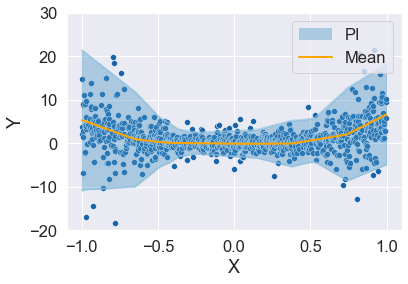

The overall coverage is 0.957
The mean bandwidth for testing data is 66.81306400350597


In [14]:
# Test 4 (Test 3 without constraint)

# Generate i.i.d data (Y follows a Laplace)
np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))


# Generate all Y values
Y = np.random.laplace(mean_Y, std_dev_Y)



X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain variance estimator
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
# quantile = [0.6,0.7,0.8,0.9]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
E_t = E_t.T

# solve optimization problem

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 3)
#V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,[-20,30])